# In our last tutorial, we learned how to download light curves in bulk from Filtergraph. Let's take from what we learned in the Photometry tutorial and try to clean up these pre-processed light curves a bit more.

In [1]:
# First import these modules

# These are used to employ your computers operating system (os) to
# search through your directories for specific files.
import glob, os
from os import listdir
from os.path import isfile, join
import fnmatch

# These are used for plotting and numerical tasks
import matplotlib.pyplot as plt
from matplotlib import pylab
from pylab import *
import numpy as np

In [2]:
#Now we're going to define a variable with the path name of where our light curves are located

#path where data is stored
SectorNum = int(input()) #<--- will ask you for Sector number: enter 1, 2, 3, etc
#^^^ A new entry field underthis cell will open and will not proceed without an input number.
# Since we are checking out Sector 1, enter 1.

print("TESS Sector",'{:02d}'.format(SectorNum)) 
# ^^^ This adds a 0 in front of numbers 1-9. For numbers 10 and greater, this will not put a 0 in front.

path = '/Users/felizd/Desktop/TESS/Sector'+str('{:02d}'.format(SectorNum))+'/curves/clean'

#path where figures will be saved
figpath = '/Users/felizd/Desktop/TESS/Sector'+str('{:02d}'.format(SectorNum))+'/plots/' 

#path where we will save our light curves later
savepath = '/Users/felizd/Desktop/TESS/Sector'+str('{:02d}'.format(SectorNum))+'/processed/' 

#This portion of code is designed to recursively search through a directory 
#for all files in the path that end with .lc in their filename
data = [os.path.join(dirpath, f) # an array of path names to be looped over
    for dirpath, dirnames, files in os.walk(path) #recursively searches through directory
    for f in fnmatch.filter(files, '*.lc')] #finds every file (*) that ends with .lc

print ("number of files: ",len(data)) #number of files)

1
TESS Sector 01
number of files:  24


In [3]:
print(path)
print(figpath)


/Users/felizd/Desktop/TESS/Sector01/curves/clean
/Users/felizd/Desktop/TESS/Sector01/plots/


## Now, let's see what these light curves look like by creating a for loop to load in each .lc file

Note: for for-loops, you can use any variable, not just x. Below I use "ii". 

/Users/felizd/Desktop/TESS/Sector01/plots/TIC_114919247_Sector01_Camera_1_CCD_1.png


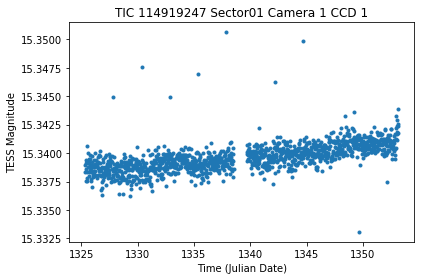

 
/Users/felizd/Desktop/TESS/Sector01/plots/TIC_114985772_Sector01_Camera_1_CCD_1.png


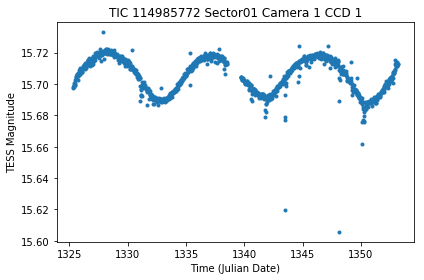

 
/Users/felizd/Desktop/TESS/Sector01/plots/TIC_115175750_Sector01_Camera_1_CCD_1.png


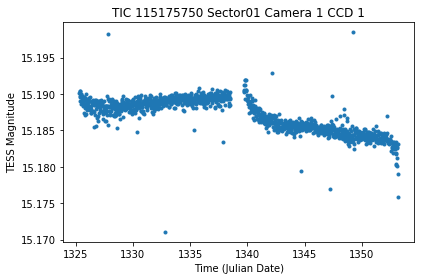

 
/Users/felizd/Desktop/TESS/Sector01/plots/TIC_126583789_Sector01_Camera_1_CCD_1.png


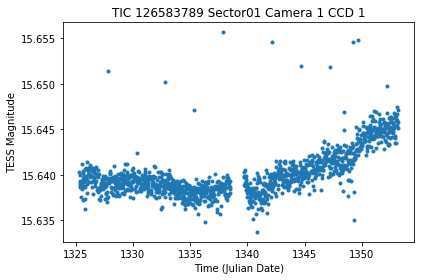

 
/Users/felizd/Desktop/TESS/Sector01/plots/TIC_126909993_Sector01_Camera_1_CCD_1.png


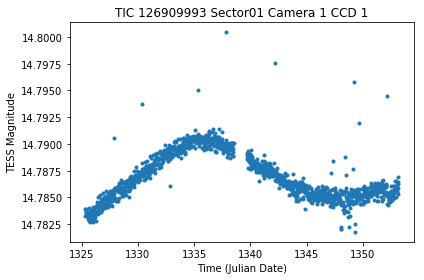

In [4]:
# for ii in range(len(data)): #<--- will print every light curve file in path
for ii in range(5): #just printing the first 5 light curve files
    
    d = np.loadtxt(data[ii])
    
    time = np.transpose(d)[0]
    magnitude = np.transpose(d)[1]
    magnitude_error = np.transpose(d)[2]
    
    ID = (os.path.basename(data[ii]).split)('_')[0]
    
    Sector = "S"+(os.path.basename(data[ii]).split)('_')[1][1:] #by default, this has lower case "s"
    #^^^ so I added a capital "S" and remove the first element ("s") of this string
    # with this index slice [1:]. This isn't really imporant, just being tidy.
    
    Camera = (os.path.basename(data[ii]).split)('_')[2] 
    CCD = (os.path.basename(data[ii]).split)('_')[3][-4]
    
    plt.plot(time,magnitude,marker='.',linestyle='none')
    plt.title("TIC "+ID+" "+Sector+" Camera "+ Camera+" CCD "+ CCD)
    
    plt.xlabel("Time (Julian Date)")
    plt.ylabel("TESS Magnitude")
    plt.tight_layout()
    
    
    
    #We can use our defined variables from our light curve's filenames to save these figures
    print(figpath+"TIC_"+ID+"_"+Sector+"_Camera_"+ Camera+"_CCD_"+ CCD+".png")
    
    plt.savefig(figpath+"TIC_"+ID+"_"+Sector+"_Camera_"+ Camera+"_CCD_"+ CCD+".png")
    plt.show()
    
    print(" ") #<--- adds a space between figures when printed out below

## Let's try applying a Savitsky-Golay filter to these light curves and then remove some outliers.

In [5]:
from scipy.signal import savgol_filter

# To remove outliers effectively, let's use Chauvent's Criteron.

# Below is a custom function to remove outliers in our light curves.
# This is a less aggresive approach than a 3*standard deviation
# cut that is commonly used in astronomy.

def ChauventsCriteron(x, y, z, mean=None, stdv=None):
    from scipy.special import erfc
    if mean is None:
        mean = y.mean()           # Mean of incoming array y
    if stdv is None:
        stdv = y.std()            # Its standard deviation
    N = len(y)                   # Lenght of incoming arrays
    criterion = 1.0/(2*N)        # Chauvenet's criterion
    d = abs(y-mean)/stdv         # Distance of a value to mean in stdv's
    d /= 2.0**0.5                # The left and right tail threshold values
    prob = erfc(d)               # Area normal dist.    
    filter = prob >= criterion   # The 'accept' filter array with booleans
    
    xf = x[filter]; yf = y[filter]; zf=z[filter]
#     print ("criterion: ", criterion)
#     print ("3*std:", std(y))
#     return filter                # Use boolean array outside this function
    return xf,yf,zf
# For some light curves, where there are flare events, we may need to 
# turn this off. (Will add in future versions)


In [37]:
#Let's make some temporary variables to avoid overwriting time,flux and flux_error

t=time; m=magnitude; me=magnitude_error #Note: with ";" you can end a line of code. 
#    ^^^It can be useful to declutter your scripts (one line versus three).

cad = t[1]-t[0] # seperation in time, between data points (in units of days). Should be same for all data sets.
print(cad)

print("cadence: ")
print(cad," days; in hours: ",cad*24.0)

#now let's define a window size to smooth our data with:
print(" ")
window_size = int(5.0/cad) #number of data points in 5 hours
if (window_size % 2) == 0: #must be odd. If not, there will be an error
    window_size = window_size+1
print("number of data points in ",5," hours: ",window_size)

#let's test a list of different window sizes
window_size = [11,51,101,171,243,987] #must be odd numbers

print(len(window_size))
print(" ")
for a in range(len(window_size)):
    window = window_size[a]
    print(window)

0.020752000000129556
cadence: 
0.020752000000129556  days; in hours:  0.49804800000310934
 
number of data points in  5  hours:  241
6
 
11
51
101
171
243
987


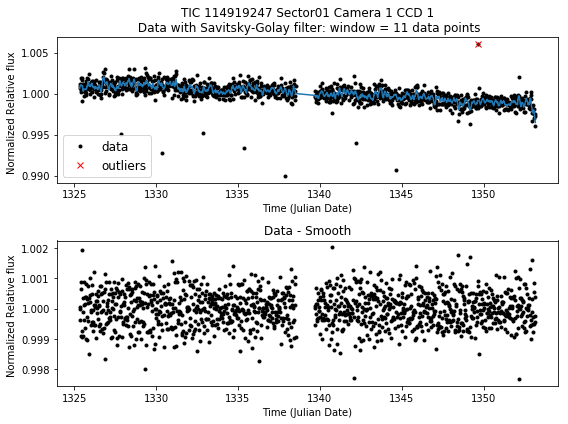

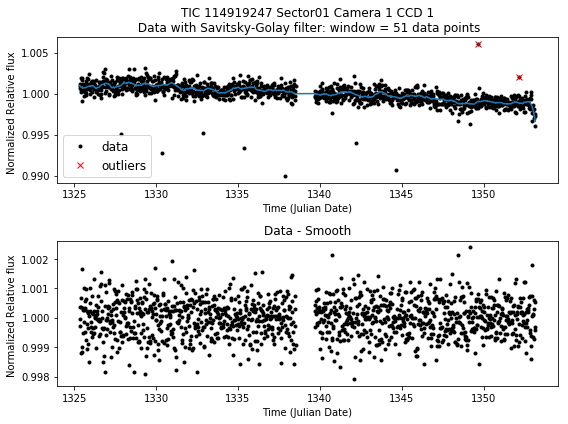

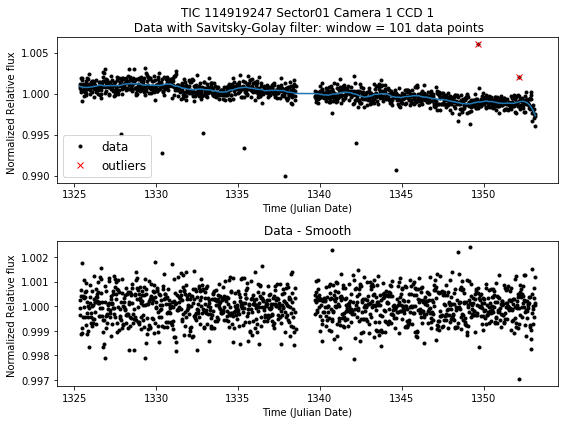

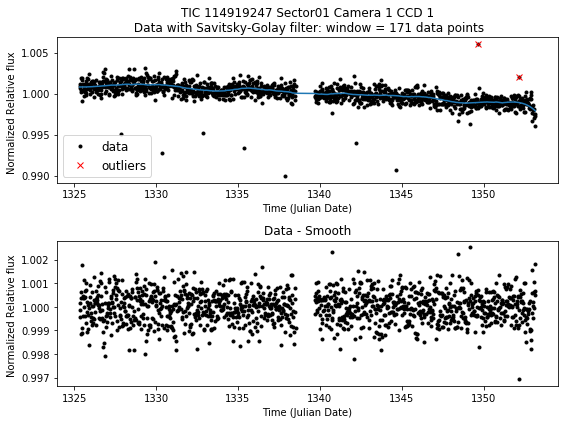

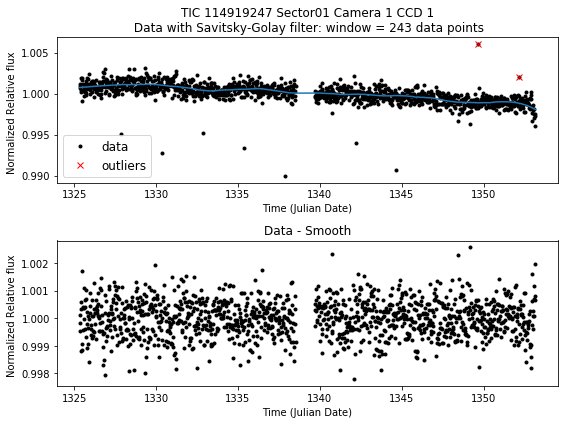

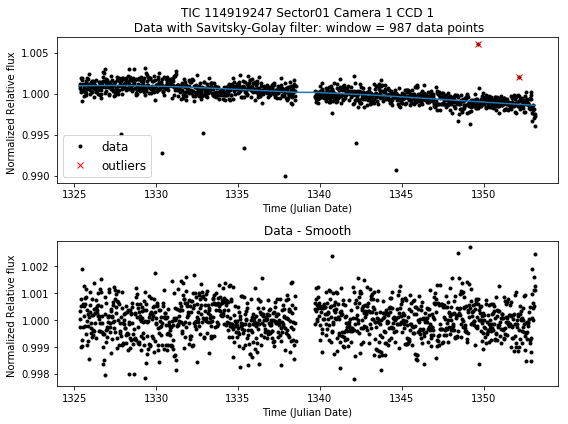

In [36]:
# for ii in range(len(data)): #<--- will print every light curve file in path
for ii in range(1): #just printing the first 5 light curve files
    d = np.loadtxt(data[ii])
    
    x = np.transpose(d)[0] #time
    mm = np.transpose(d)[1] #magnitude
    mme = np.transpose(d)[2] #magnitude error
    
    #  to convert from magnitude to flux, you can use the following approximation:
    y = 10.0**(mm/-2.5) #flux
    # let's normalize our flux by dividing by its average
    y = 10.0**(mm/-2.5)/np.mean(10.0**(mm/-2.5)) #now it should be centered on 1

    # to convert magnitude errors to flux errors, you can use the following approximation:
    z = y*( 1- 10.0**(mme/-2.5) )
    
    
    ID = (os.path.basename(data[ii]).split)('_')[0]
    
    Sector = "S"+(os.path.basename(data[ii]).split)('_')[1][1:] #by default, this has lower case "s"
    #^^^ so I added a capital "S" and remove the first element ("s") of this string
    # with this index slice [1:]. This isn't really imporant, just being tidy.
    
    Camera = (os.path.basename(data[ii]).split)('_')[2] 
    CCD = (os.path.basename(data[ii]).split)('_')[3][-4]
    
    
    for a in range(len(window_size)):
        window = window_size[a]
    
    
        o = np.ones(len(y), dtype=bool)

        #     lets smooth for a total of 10 times. Experiment with more or less iterations:
        for i in range(10):  #Note: You can place a for-loop inside a for-loop!
            y_prime = np.interp(t, t[o], y[o])
            smooth = savgol_filter(y_prime, window, polyorder=3)
            resid = y - smooth
            sigma = np.sqrt(np.mean(resid**2)) #root mean square (RMS for short)
            o0 = np.abs(resid) < 3*sigma #this is shorthand for: -3*sigma < resid < 3*sigma
            if o.sum() == o0.sum():
                o = o0
                break
            o = o0

        # Only discard positive outliers
        o = resid < 3.0*sigma

        #removing outliers with Chauvenet's criterion after smoothing
        t2,f2,fe2 = ChauventsCriteron(t,smooth-y+1,z)


        fig=plt.figure(figsize=(8, 6))
        fig.add_subplot(211)
        plt.plot(t, y, "k.", label="data")
        plt.plot(t, smooth)
        plt.plot(t[~o], y[~o], "xr", label="outliers")

        plt.title("TIC "+ID+" "+Sector+" Camera "+ Camera+" CCD "+ CCD + "\n Data with Savitsky-Golay filter: window = "+str(window)+" data points")
        plt.xlabel("Time (Julian Date)")
        plt.ylabel("Normalized Relative flux ")
        plt.legend(fontsize=12)

        fig.add_subplot(212)
        plt.title("Data - Smooth")
        plt.plot(t2, f2,"k.")
        plt.xlabel("Time (Julian Date)")
        plt.ylabel("Normalized Relative flux ")
        fig.subplots_adjust(hspace=0.4)
        fig.tight_layout()
        plt.show()
    
    print(" ")
    
    
    #save smoothed results to new text files
    np.savetxt(savepath+'TIC_'+ID+'_lightcurve_cleaned.txt', list(zip(t,smooth-y+1,z)) )
    
    

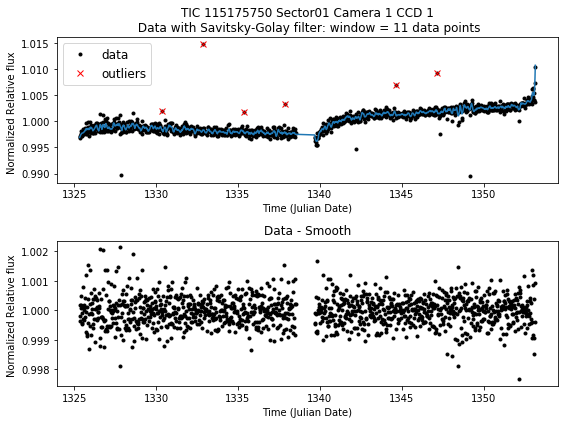

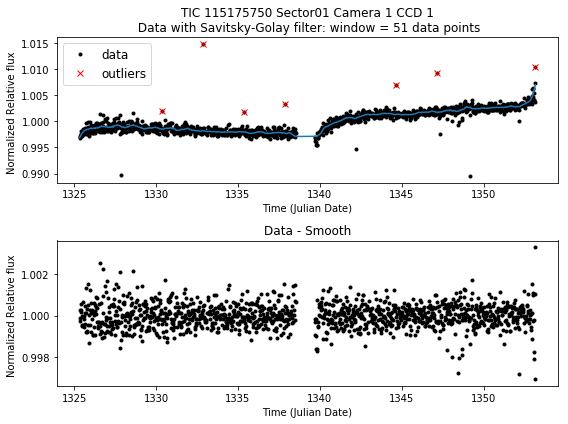

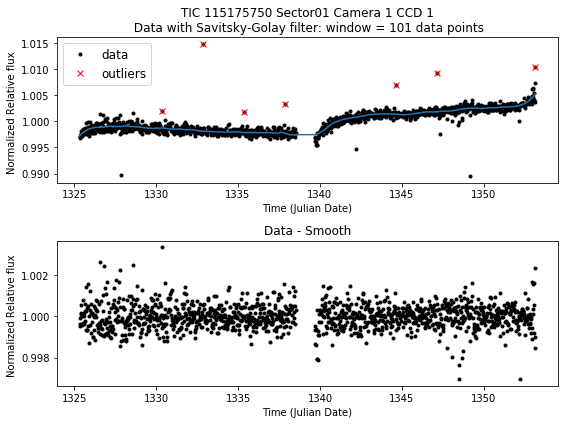

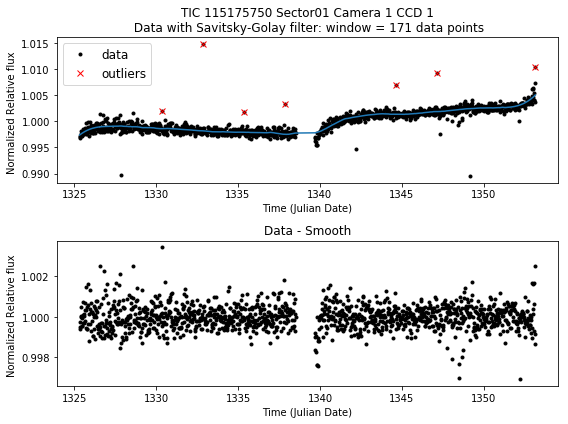

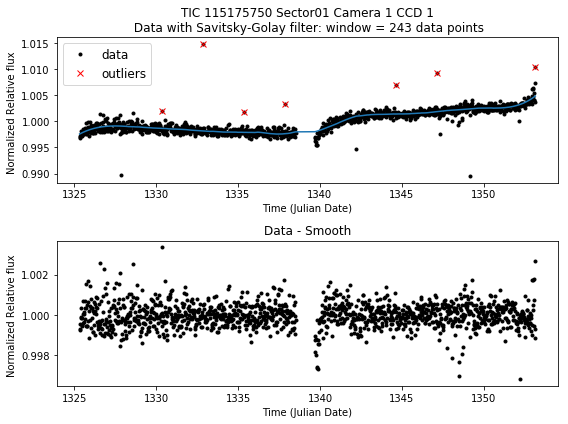

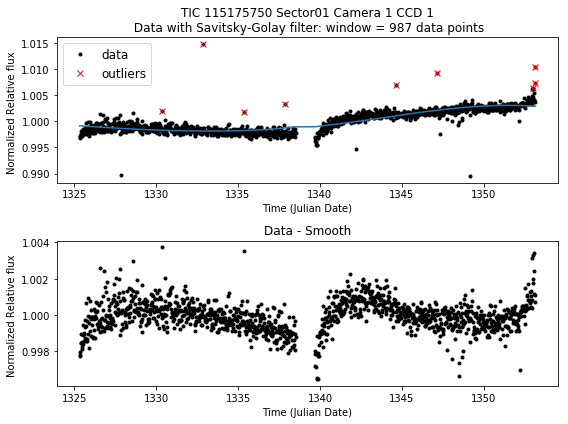

In [41]:
ii= 2
    
d = np.loadtxt(data[ii])

x = np.transpose(d)[0] #time
mm = np.transpose(d)[1] #magnitude
mme = np.transpose(d)[2] #magnitude error

#  to convert from magnitude to flux, you can use the following approximation:
y = 10.0**(mm/-2.5) #flux
# let's normalize our flux by dividing by its average
y = 10.0**(mm/-2.5)/np.mean(10.0**(mm/-2.5)) #now it should be centered on 1

# to convert magnitude errors to flux errors, you can use the following approximation:
z = y*( 1- 10.0**(mme/-2.5) )


ID = (os.path.basename(data[ii]).split)('_')[0]

Sector = "S"+(os.path.basename(data[ii]).split)('_')[1][1:] #by default, this has lower case "s"
#^^^ so I added a capital "S" and remove the first element ("s") of this string
# with this index slice [1:]. This isn't really imporant, just being tidy.

Camera = (os.path.basename(data[ii]).split)('_')[2] 
CCD = (os.path.basename(data[ii]).split)('_')[3][-4]


for a in range(len(window_size)):
    window = window_size[a]


    o = np.ones(len(y), dtype=bool)

    #     lets smooth for a total of 10 times. Experiment with more or less iterations:
    for i in range(10):  #Note: You can place a for-loop inside a for-loop!
        y_prime = np.interp(t, t[o], y[o])
        smooth = savgol_filter(y_prime, window, polyorder=3)
        resid = y - smooth
        sigma = np.sqrt(np.mean(resid**2)) #root mean square (RMS for short)
        o0 = np.abs(resid) < 3*sigma #this is shorthand for: -3*sigma < resid < 3*sigma
        if o.sum() == o0.sum():
            o = o0
            break
        o = o0

    # Only discard positive outliers
    o = resid < 3.0*sigma

    #removing outliers with Chauvenet's criterion after smoothing
#     t2,f2,fe2 = ChauventsCriteron(t,smooth-y+1,z)
    t2,f2,fe2 = ChauventsCriteron(t,resid+1,z)


    fig=plt.figure(figsize=(8, 6))
    fig.add_subplot(211)
    plt.plot(t, y, "k.", label="data")
    plt.plot(t, smooth)
    plt.plot(t[~o], y[~o], "xr", label="outliers")

    plt.title("TIC "+ID+" "+Sector+" Camera "+ Camera+" CCD "+ CCD + "\n Data with Savitsky-Golay filter: window = "+str(window)+" data points")
    plt.xlabel("Time (Julian Date)")
    plt.ylabel("Normalized Relative flux ")
    plt.legend(fontsize=12)

    fig.add_subplot(212)
    plt.title("Data - Smooth")
    plt.plot(t2, f2,"k.")
    plt.xlabel("Time (Julian Date)")
    plt.ylabel("Normalized Relative flux ")
    fig.subplots_adjust(hspace=0.4)
    fig.tight_layout()
    plt.show()
    
    print(" ")
    
    
    #save smoothed results to new text files
    np.savetxt(savepath+'TIC_'+ID+'_lightcurve_cleaned.txt', list(zip(t,smooth-y+1,z)) )
    
    

## These are pretty clean! I think we're ready for planet hunting!

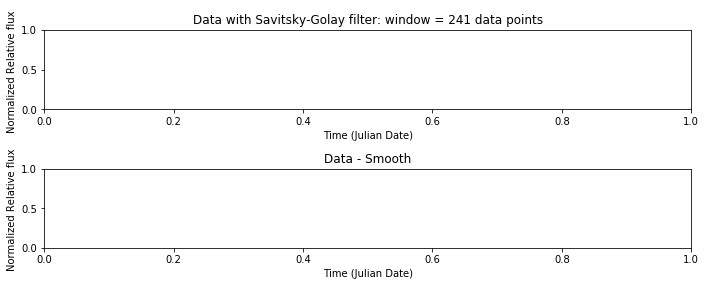

In [14]:
fig=plt.figure(figsize=(10, 4))

fig.add_subplot(211)
plt.title("Data with Savitsky-Golay filter: window = "+str(window_size)+" data points")
plt.xlabel("Time (Julian Date)")
plt.ylabel("Normalized Relative flux ")

fig.add_subplot(212)
plt.title("Data - Smooth")
plt.xlabel("Time (Julian Date)")
plt.ylabel("Normalized Relative flux ")


fig.subplots_adjust(hspace=0.4)
fig.tight_layout()
plt.show()